In [14]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint
import re
import warnings
warnings.filterwarnings("ignore")
# import torch_xla
# import torch_xla.core.xla_model as xm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
filepath = 'warpeace.txt'

with open(filepath, 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# Preprocess the text
text = text.lower()
text = re.sub(r'[^a-z\s\.]', '', text) 
words = text.split()
words = [word for word in words if word] 

words = [word for word in words if len(word) > 1]
print(len(words))
words = pd.Series(words)

546565


In [7]:
# Build vocabulary
unique_words = sorted(set(words))
stoi = {s: i + 1 for i, s in enumerate(unique_words)}  
stoi['.'] = 0  # End-of-sentence token
itos = {i: s for s, i in stoi.items()}

# Prepare input-output pairs
block_size = 5
X, Y = [], []

for i in range(len(words) - block_size):
    context = [0] * block_size 
    for j in range(block_size):
        context[j] = stoi[words[i + j]]
    X.append(context)
    Y.append(stoi[words[i + block_size]]) 

print(len(X))
print(len(Y))

546560
546560


In [8]:
X = torch.tensor(X, dtype=torch.long)  # Input tensor
Y = torch.tensor(Y, dtype=torch.long)  # Output tensor

In [9]:
X

tensor([[24775, 17297, 20822,  9482,   801],
        [17297, 20822,  9482,   801, 13433],
        [20822,  9482,   801, 13433,  1163],
        ...,
        [18167,  5793, 15440, 24889, 24692],
        [ 5793, 15440, 24889, 24692,  1163],
        [15440, 24889, 24692,  1163, 15177]])

In [10]:
emb_dim = 64 
hidden_size = 1024  

class NextWord(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1) 
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

# Initialize the model
model = NextWord(block_size, len(stoi), emb_dim, hidden_size).to(device)
model = model.to(device)

In [11]:
def generate_word(model, itos, stoi, block_size, max_len=10):
    context = [0] * block_size
    words_generated = []
    
    for _ in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        word = itos[ix]
        if word == '.':
            break
        words_generated.append(word)
        context = context[1:] + [ix] 

    return ' '.join(words_generated)

In [12]:
"""
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)

# Mini-batch training
batch_size = 13486
num_epochs = 1000  # You can train for more epochs
print_every = 100  # Print every 10 mini-batches

for epoch in range(num_epochs):
    # Shuffle data at the beginning of each epoch
    permutation = torch.randperm(len(X))
    X = X[permutation]
    Y = Y[permutation]

    for i in range(0, len(X) - (len(X)%batch_size), batch_size):
        x = X[i:i + batch_size].to(device)
        y = Y[i:i + batch_size].to(device)
        
        # Forward pass
        y_pred = model(x)
        print('Done')
        
        # Compute loss
        loss = loss_fn(y_pred, y)
        
        # Backpropagation
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        opt.step()
        opt.zero_grad()

        # Print loss periodically
        if i % print_every == 0:
            print(f"Epoch [{epoch}], Loss: {loss.item():.4f}")
    
    # Print loss after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")
"""

'\nloss_fn = nn.CrossEntropyLoss()\nopt = torch.optim.AdamW(model.parameters(), lr=0.01)\n\n# Mini-batch training\nbatch_size = 13486\nnum_epochs = 1000  # You can train for more epochs\nprint_every = 100  # Print every 10 mini-batches\n\nfor epoch in range(num_epochs):\n    # Shuffle data at the beginning of each epoch\n    permutation = torch.randperm(len(X))\n    X = X[permutation]\n    Y = Y[permutation]\n\n    for i in range(0, len(X) - (len(X)%batch_size), batch_size):\n        x = X[i:i + batch_size].to(device)\n        y = Y[i:i + batch_size].to(device)\n        \n        # Forward pass\n        y_pred = model(x)\n        print(\'Done\')\n        \n        # Compute loss\n        loss = loss_fn(y_pred, y)\n        \n        # Backpropagation\n        loss.backward()\n        \n        # Gradient clipping\n        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)\n        \n        # Update weights\n        opt.step()\n        opt.zero_grad()\n\n        # Print lo

In [ ]:

# torch.save(model, 'model.pth')
# torch.save(model.state_dict(), '/kaggle/working/next_word_model.pth')
# print("Model weights saved to /kaggle/working/next_word_model.pth")

"""
# Function to preprocess the input sentence
def preprocess_input(sentence, stoi, block_size):
    sentence = sentence.lower()  # Convert to lowercase
    sentence = re.sub(r'[^a-z\s\.]', '', sentence)  # Remove special characters except full stops
    words = sentence.split()  # Split into words
    words = [word for word in words if word]  # Remove empty strings

    # Create context from the last block_size words
    context = [0] * block_size  # Start with the end-of-sentence token
    for i in range(block_size):
        if i < len(words):
            word = words[i]
            context[i] = stoi.get(word, 0)  # Get the index, use 0 if word not in vocab
        else:
            context[i] = 0  # Fill with end-of-sentence token if fewer words

    return context

# Input sentence
input_sentence = "can we really say that"

# Preprocess the input sentence
context = preprocess_input(input_sentence, stoi, block_size)

# Convert context to tensor and send to device
context_tensor = torch.tensor(context, dtype=torch.long).view(1, -1).to(device)

# Generate the next word
with torch.no_grad():  # Disable gradient calculation for inference
    y_pred = model(context_tensor)  # Forward pass
    ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()  # Sample from the distribution
    next_word = itos[ix]  # Convert index to word

print(f"The predicted next word for the input '{input_sentence}' is: '{next_word}'")

"""

In [38]:
try:
    mcopy = torch.load('model-Emb64-Con5-ReLU.pth')
except:
    mcopy = torch.load('model-Emb64-Con5-ReLU.pth',map_location=device)
mcopy.eval()

# Function to preprocess the input sentence
def preprocess_input(sentence, stoi, block_size):
    sentence = sentence.lower()
    sentence = re.sub(r'[^a-z\s\.]', '', sentence)
    words = sentence.split() 
    words = [word for word in words if word] 

    context = [0] * block_size 
    for i in range(block_size):
        if i < len(words):
            word = words[i]
            context[i] = stoi.get(word, 0)
        else:
            context[i] = 0 

    return context

# Input sentence
input_sentence = "The battle was fierce but"

context = preprocess_input(input_sentence, stoi, block_size)

context_tensor = torch.tensor(context, dtype=torch.long).view(1, -1).to(device)

# Generate the next word
with torch.no_grad():
    y_pred = mcopy(context_tensor)
    ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item() 
    next_word = itos[ix] 

print(f"The predicted next word for the input '{input_sentence}' is: '{next_word}'")

The predicted next word for the input 'The battle was fierce but' is: 'on'


In [39]:
from sklearn.manifold import TSNE
# Extract word embeddings from the trained model
def extract_embeddings(model, vocab_size):
    print('Reached Function')
    with torch.no_grad():
        embeddings = model.emb.weight.cpu().numpy()  # Get the embeddings from the model
    return embeddings

# Get the word embeddings from the trained model
embeddings = extract_embeddings(model, len(stoi))

# Apply t-SNE to reduce the dimensionality of embeddings for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
print('Calling fit-transform')
embeddings_2d = tsne.fit_transform(embeddings)
print('fit-transform Done')


Reached Function
Calling fit-transform
fit-transform Done


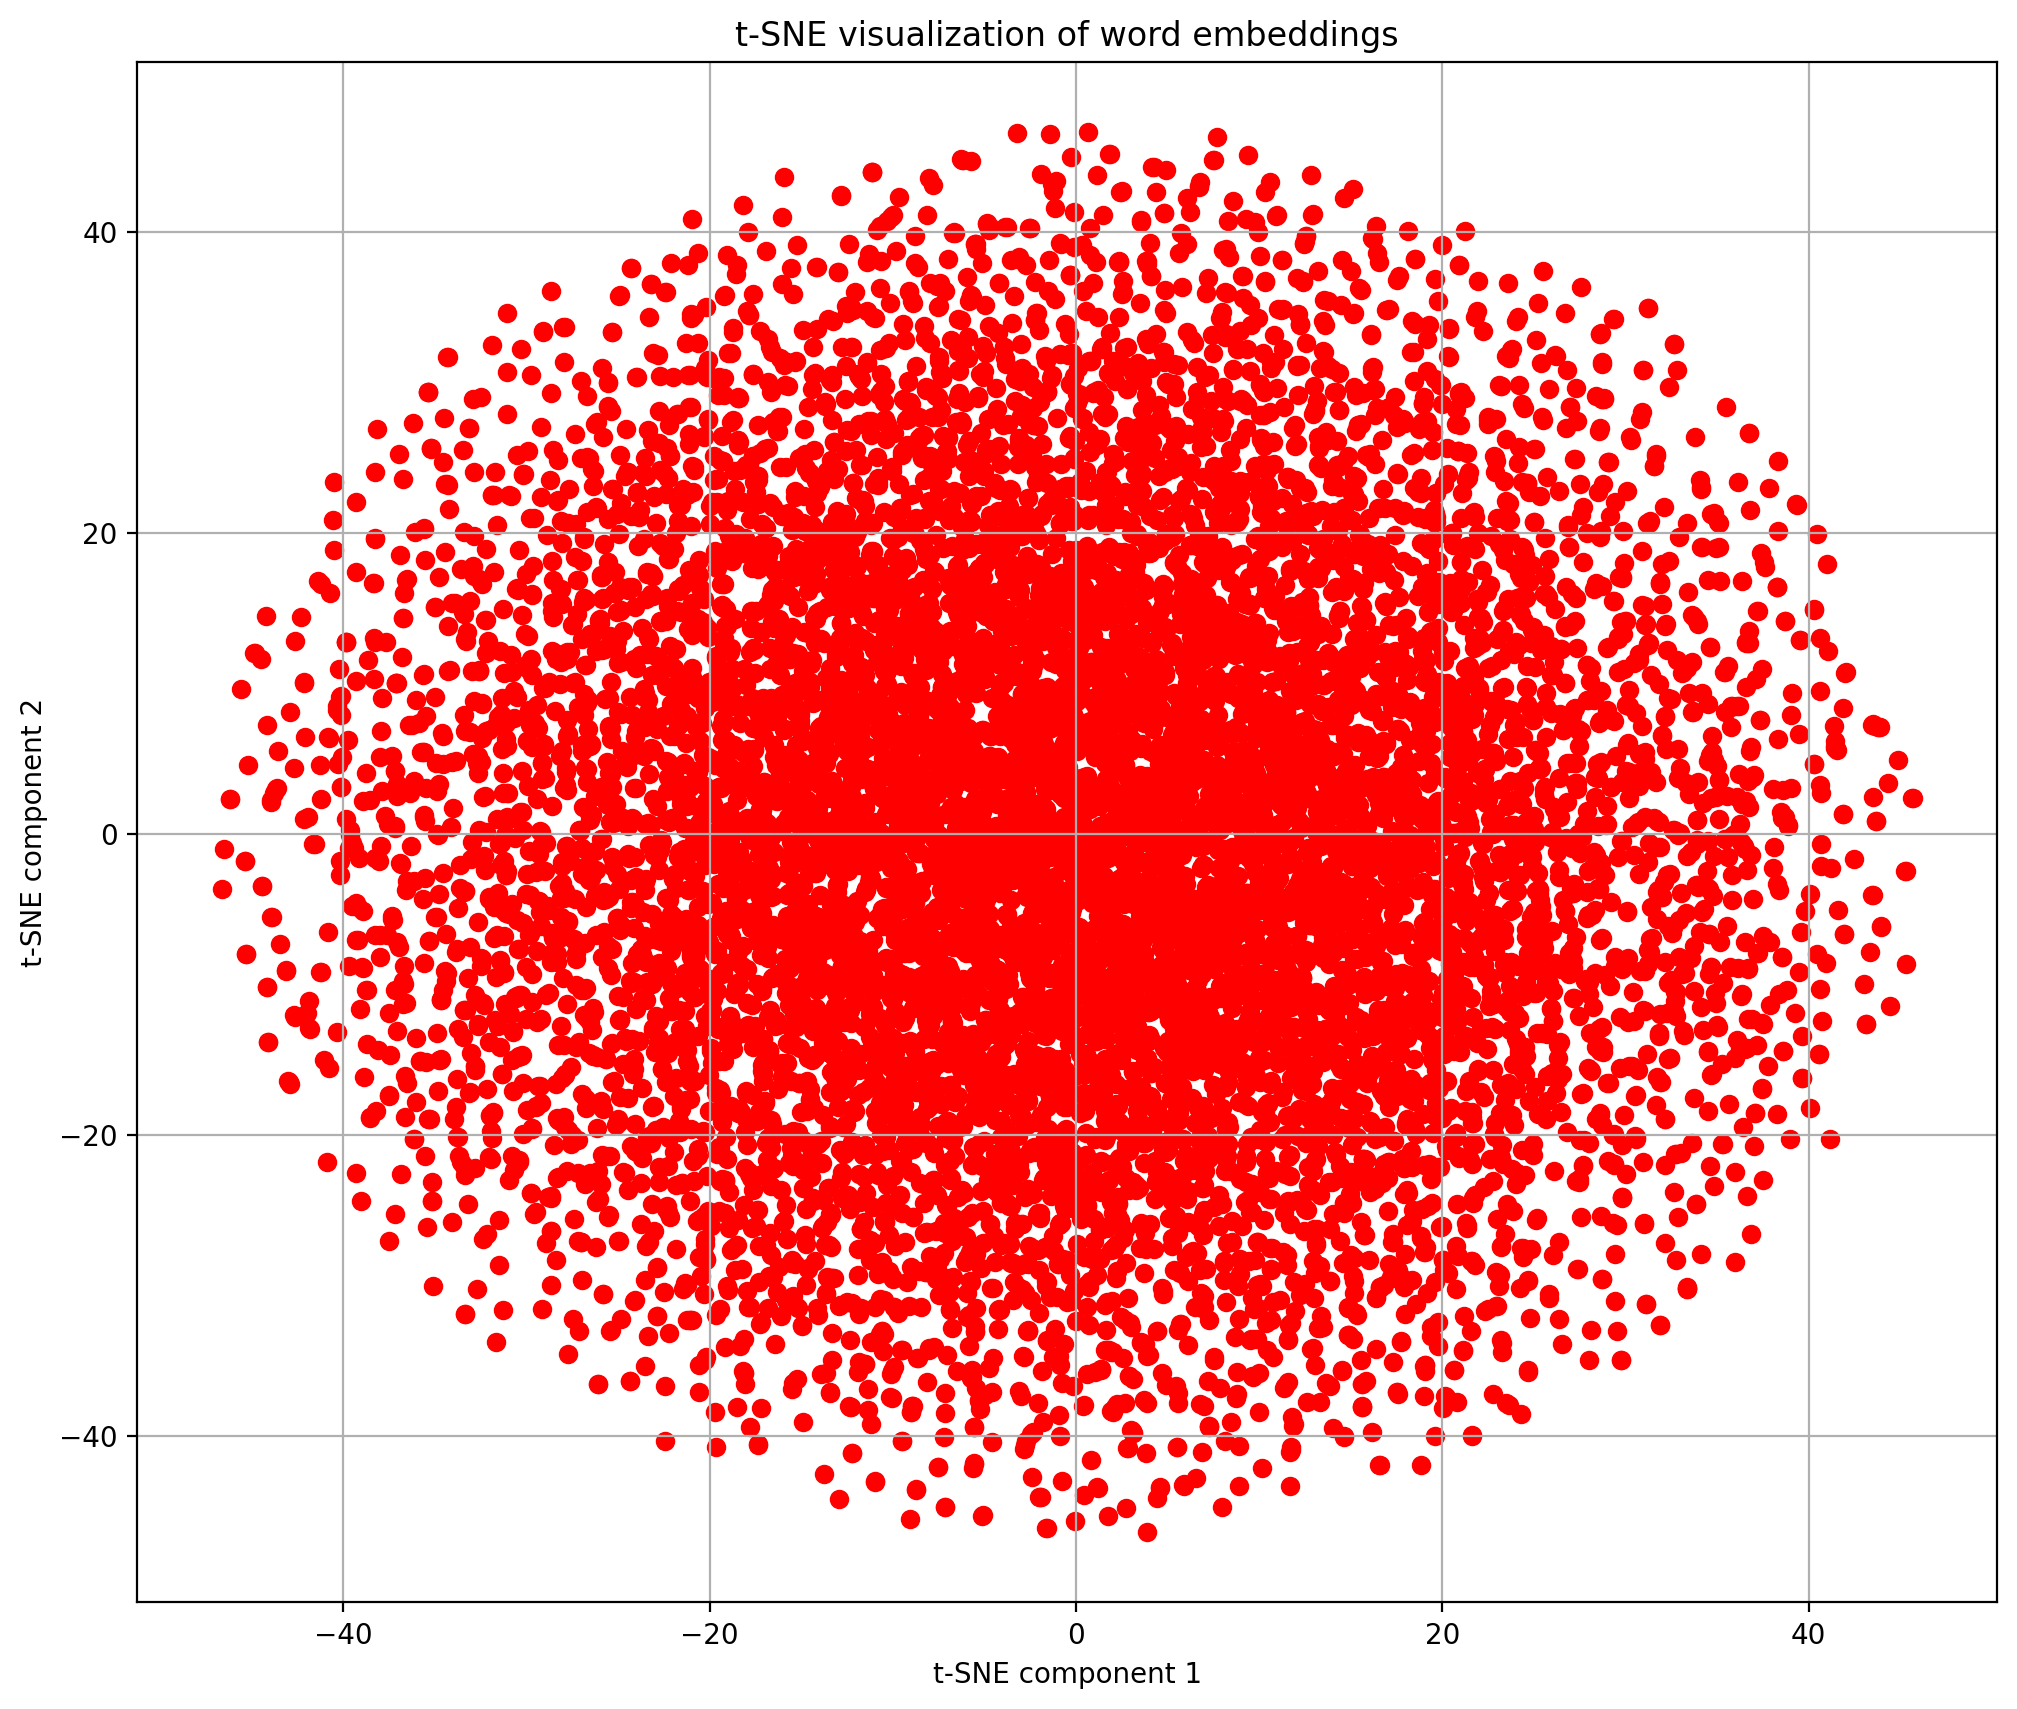

In [20]:
plt.figure(figsize=(12, 10))
for i, word in enumerate(itos.values()):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], marker='o', color='red')
    if i == 10000:
        break

plt.title("t-SNE visualization of word embeddings")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.grid(True)
plt.show()

initialing plotting
Done plotting


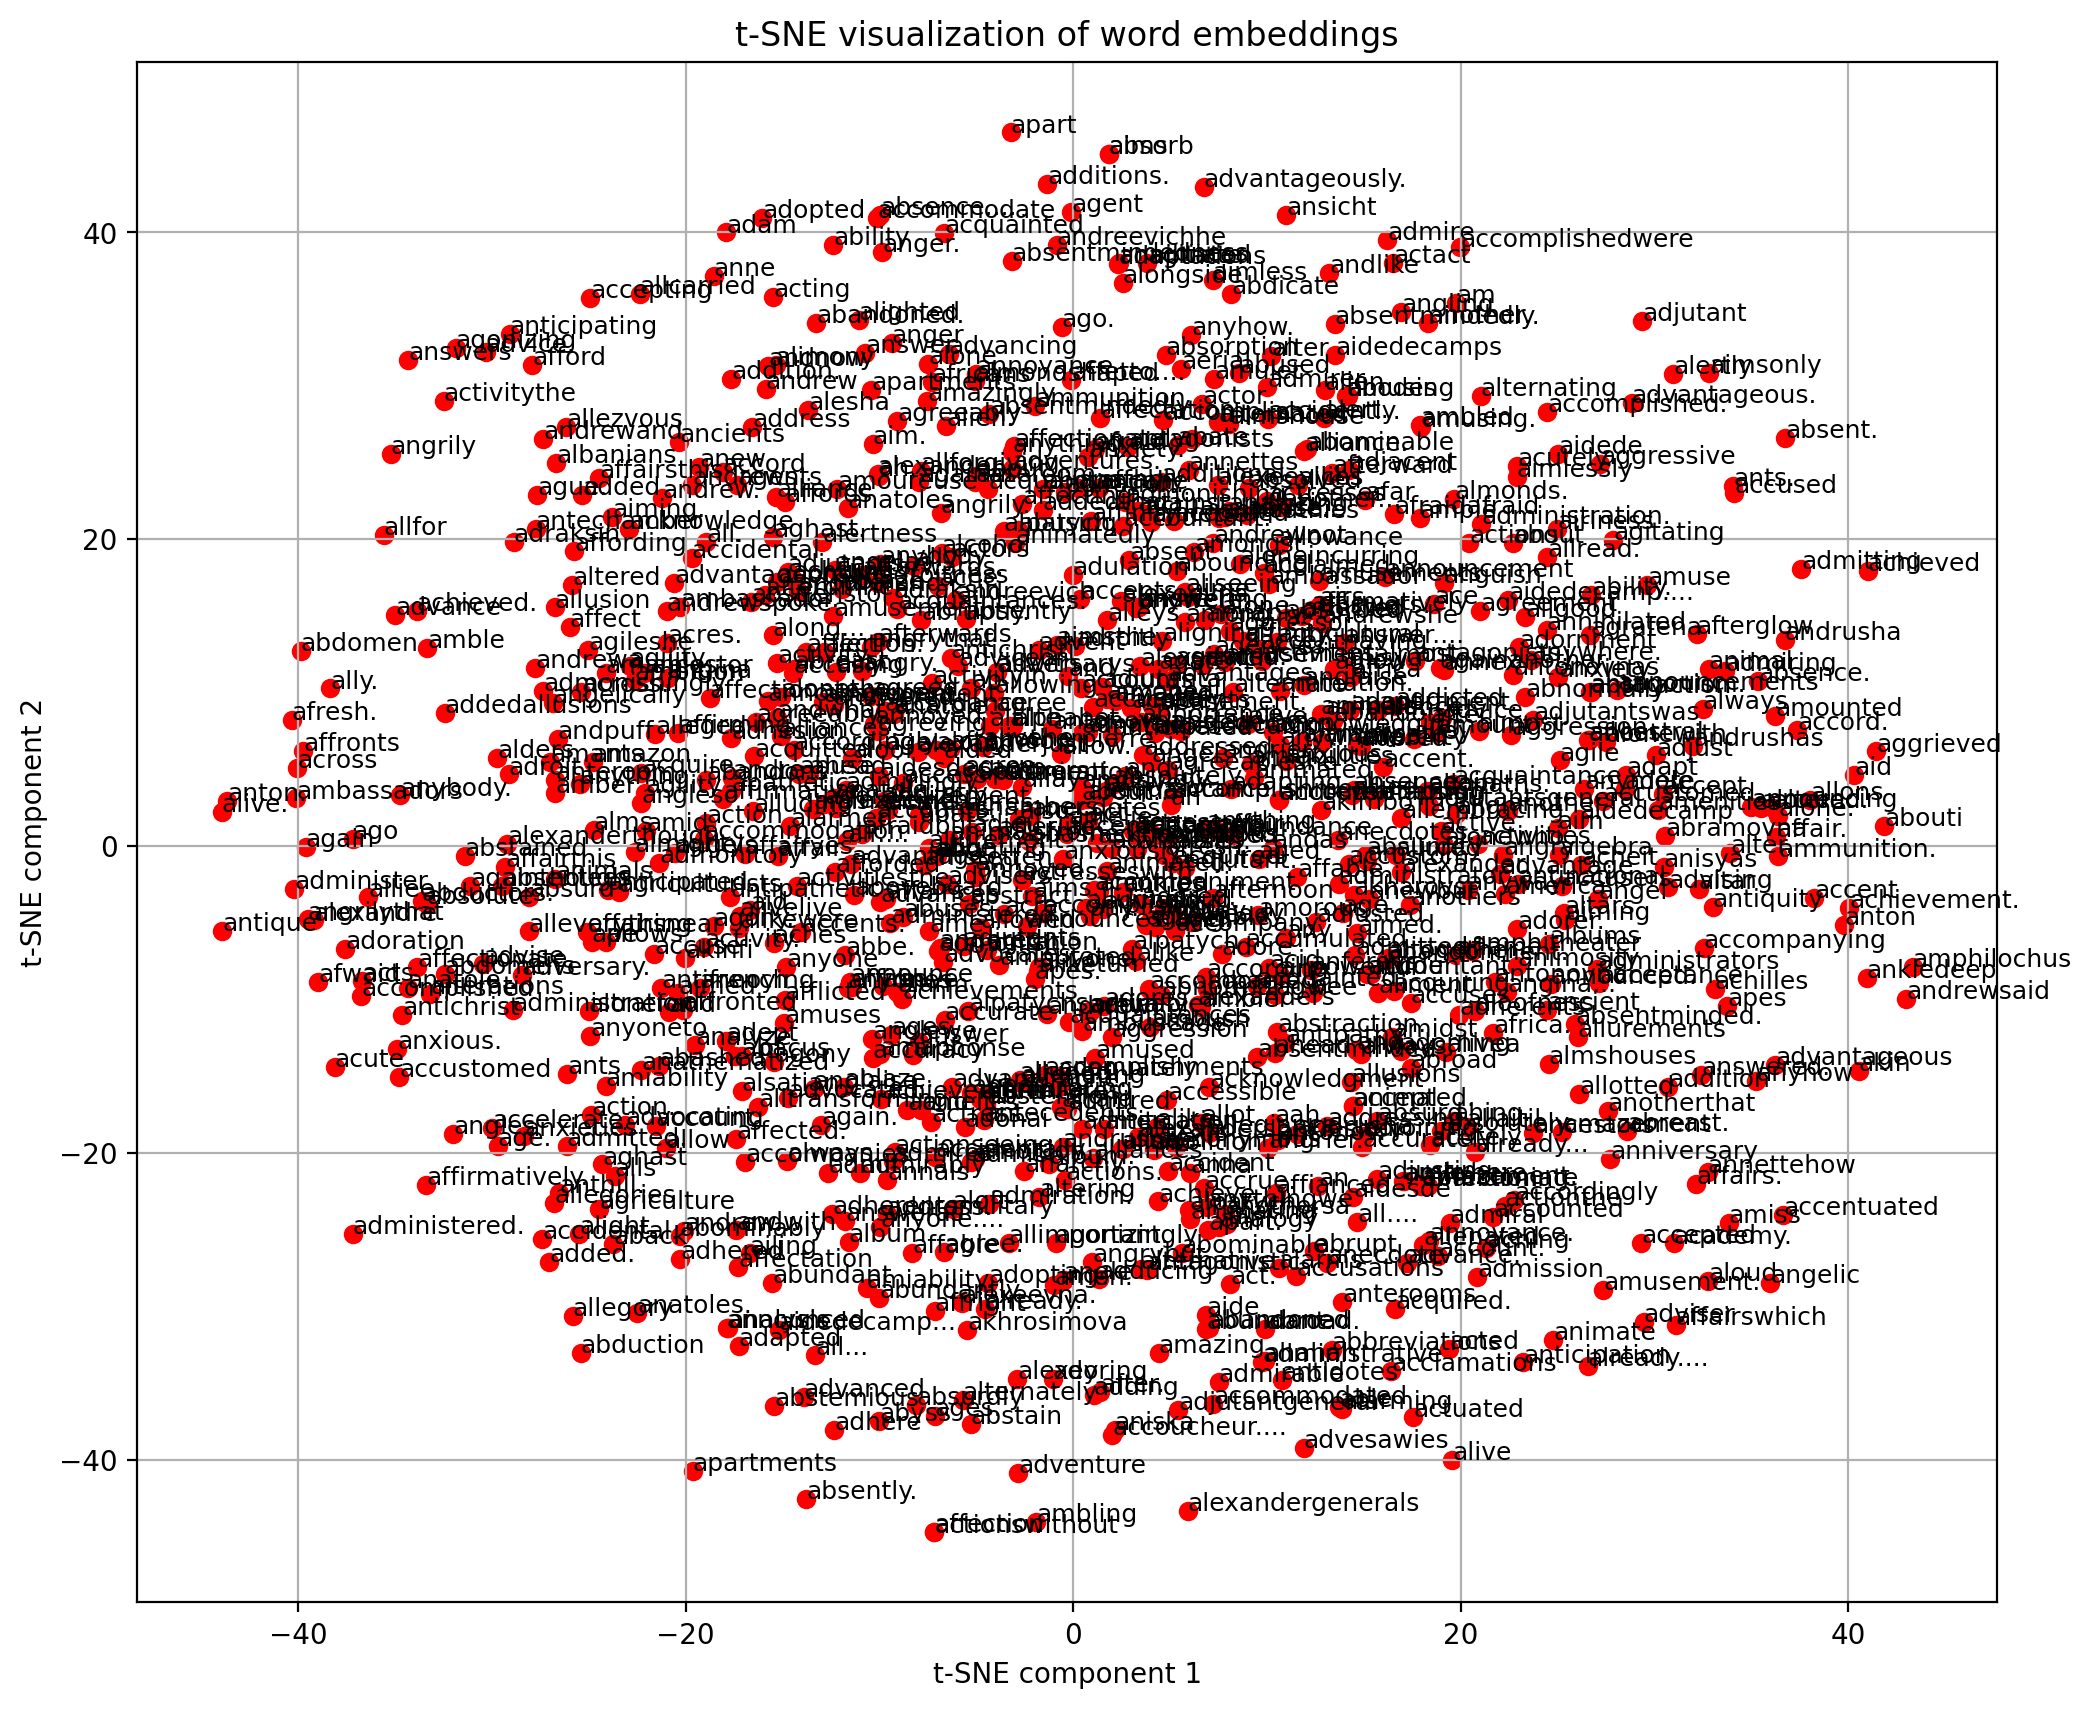

In [19]:
# Plot the t-SNE results
plt.figure(figsize=(12, 10))
print('initialing plotting')
for i, word in enumerate(itos.values()):
    if i == 1000:
        break
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], marker='o', color='red')
    plt.text(embeddings_2d[i, 0] + 0.01, embeddings_2d[i, 1] + 0.01, word, fontsize=9)
print('Done plotting')
plt.title("t-SNE visualization of word embeddings")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.grid(True)
plt.show()

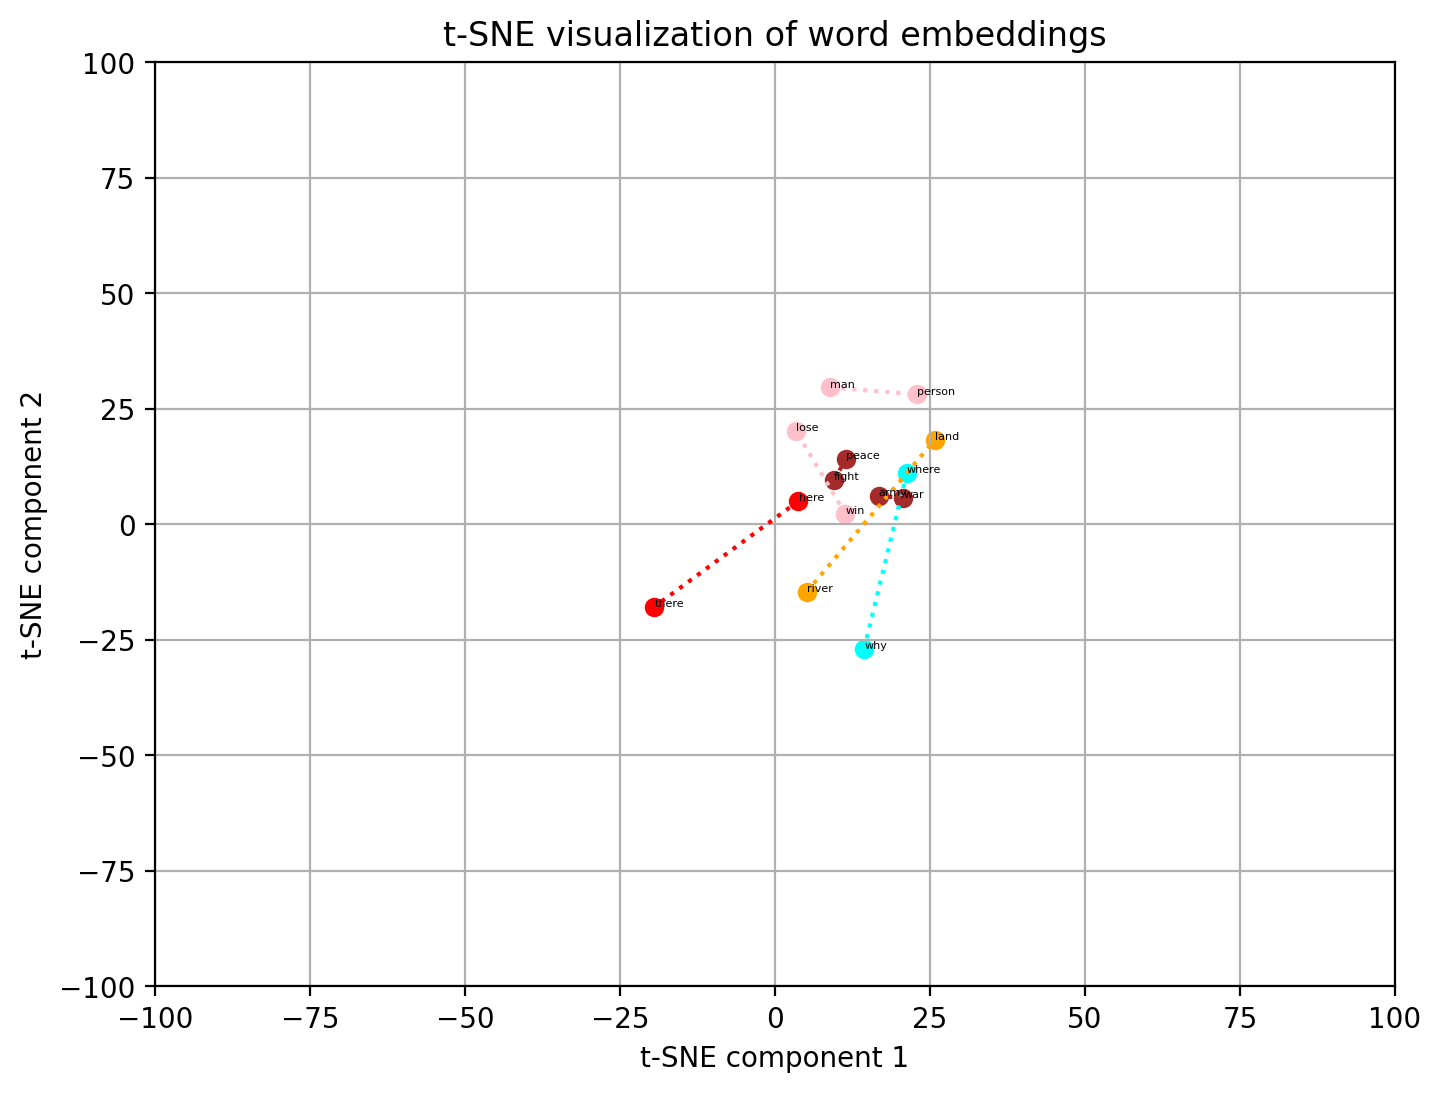

In [52]:
import matplotlib.pyplot as plt
import random

# List of synonyms to plot
wordListA = ['man','where','here', 'fight', 'river','war', 'win']
wordListB = ['person','why','there', 'peace', 'land', 'army', 'lose']

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

plt.figure(figsize=(8, 6))
plt.title("t-SNE visualization of word embeddings")

for i in range(len(wordListA)):
    wordA = wordListA[i]
    wordB = wordListB[i]
    wordA_ix = stoi[wordA]
    wordB_ix = stoi[wordB]

    # Plot word A
    color = random.choice(colors)
    plt.scatter(embeddings_2d[wordA_ix, 0], embeddings_2d[wordA_ix, 1], marker='o', color=color)
    plt.text(embeddings_2d[wordA_ix, 0] + 0.01, embeddings_2d[wordA_ix, 1] + 0.01, wordA, fontsize=4)

    # Plot word B
    plt.scatter(embeddings_2d[wordB_ix, 0], embeddings_2d[wordB_ix, 1], marker='o', color=color)
    plt.text(embeddings_2d[wordB_ix, 0] + 0.01, embeddings_2d[wordB_ix, 1] + 0.01, wordB, fontsize=4)

    # Draw a dotted line between word A and word B
    plt.plot([embeddings_2d[wordA_ix, 0], embeddings_2d[wordB_ix, 0]], 
             [embeddings_2d[wordA_ix, 1], embeddings_2d[wordB_ix, 1]], 
             color=color, linestyle='dotted')

plt.xlim((-100, 100))
plt.ylim((-100, 100))

plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.grid(True)
plt.show()


initialing plotting


KeyboardInterrupt: 

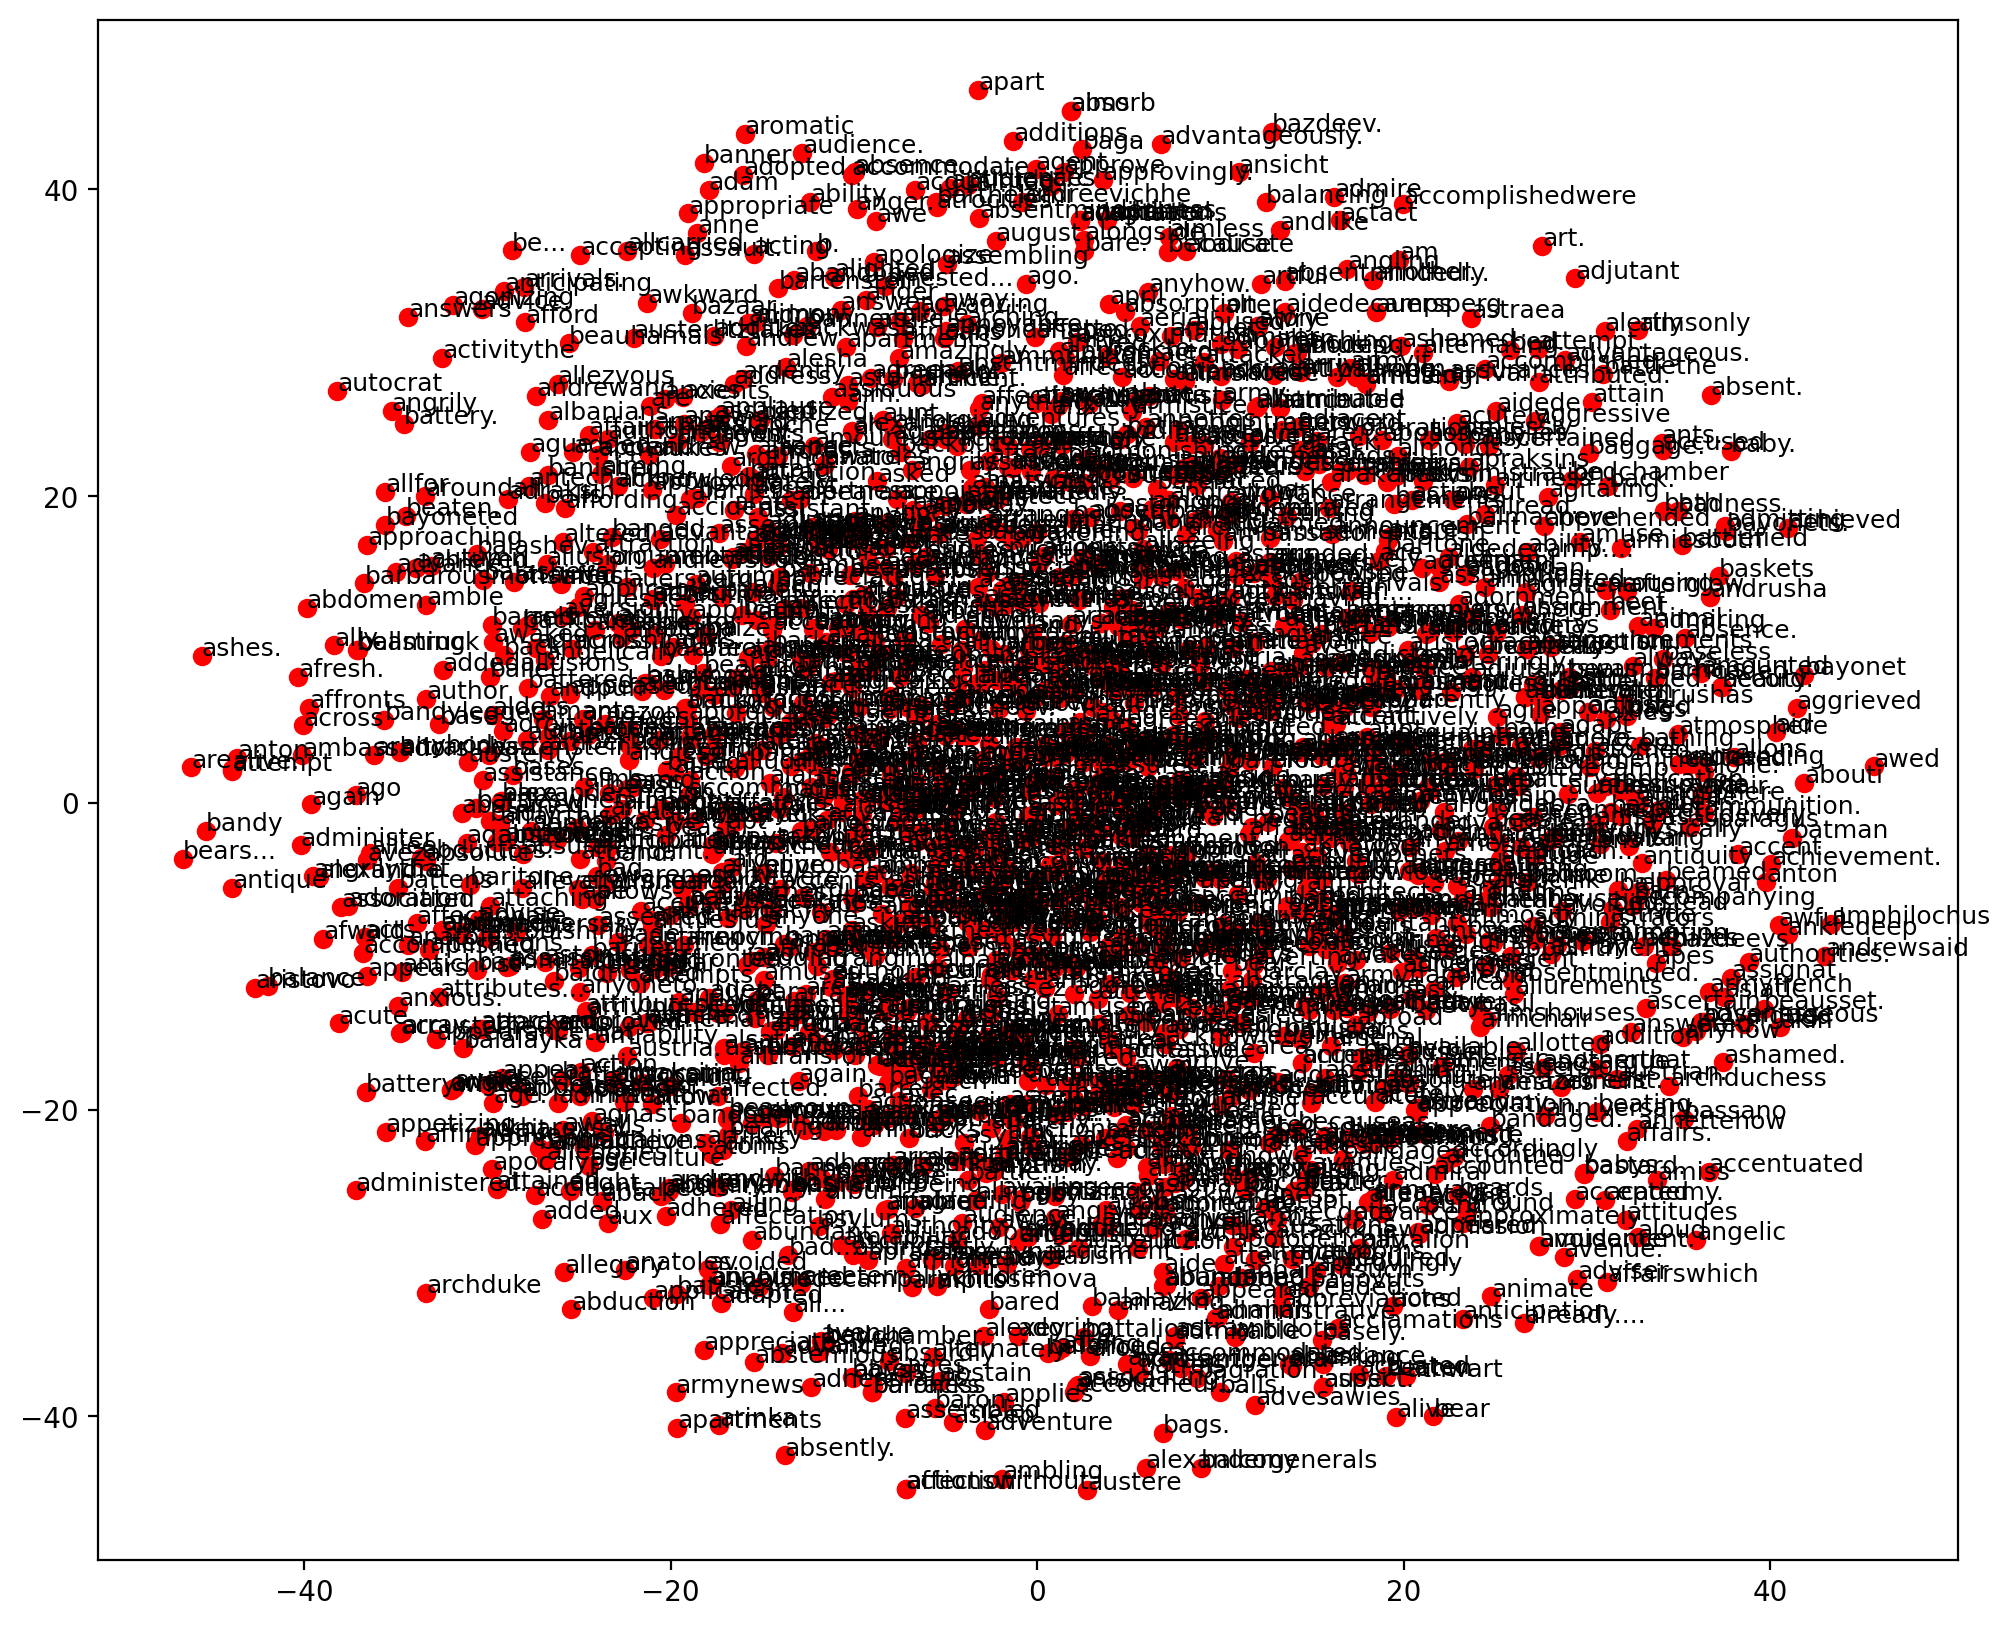

In [37]:
# Plot the t-SNE results
plt.figure(figsize=(12, 10))
print('initialing plotting')
for i, word in enumerate(itos.values()):
    if i == 5000:
        break
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], marker='o', color='red')
    plt.text(embeddings_2d[i, 0] + 0.01, embeddings_2d[i, 1] + 0.01, word, fontsize=9)
print('Done plotting')
plt.title("t-SNE visualization of word embeddings")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.grid(True)
plt.show()